# Binary Classification
This section explores the use of binary classification, a fundamental machine learning approach, to differentiate between normal and malicious activities within IoT ecosystems. We will explore and evaluate the performance of multiple supervised learning models, using a large representative dataset of IoT traffic.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, \
    classification_report, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.contingency_tables import mcnemar
from mlxtend.evaluate import mcnemar_table

## Data gathering and Pre-processing
### Load Dataset
The dataset used in this project is the Bot-IoT dataset, which can be found [here](https://www.kaggle.com/datasets/azalhowaide/iot-dataset-for-intrusion-detection-systems-ids).

In [3]:
dataframe = pd.read_csv('datasets/BotNeTIoT-L01_label_NoDuplicates.csv')
dataframe = dataframe.sample(frac=1).reset_index(drop=True) # shuffle
dataframe = dataframe.drop(dataframe.columns[0], axis=1) # drop 'id' column

In [4]:
dataframe.head()

,MI_dir_L0.1_weight,MI_dir_L0.1_mean,MI_dir_L0.1_variance,H_L0.1_weight,H_L0.1_mean,H_L0.1_variance,HH_L0.1_weight,HH_L0.1_mean,HH_L0.1_std,HH_L0.1_magnitude,...,HH_jit_L0.1_mean,HH_jit_L0.1_variance,HpHp_L0.1_weight,HpHp_L0.1_mean,HpHp_L0.1_std,HpHp_L0.1_magnitude,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,label
0,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,60.000000,...,1.505914e+09,0.000000e+00,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,0
1,6025.415416,434.091420,49285.801894,6025.415416,434.091420,49285.801894,1.000000,60.000000,0.000000,60.000000,...,1.507659e+09,0.000000e+00,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,0
2,6479.410244,387.047728,54596.952177,6479.410244,387.047728,54596.952177,4290.218074,553.917463,6.384882,553.917463,...,3.376637e-03,1.509637e+04,1.000000,554.000000,0.000000,554.000000,0.000000,0.0,0.0,0
3,6154.570937,423.597358,47389.483151,6154.570937,423.597358,47389.483151,4529.931114,553.929646,5.894917,553.929646,...,3.828086e+02,5.771387e+11,1.000000,554.000000,0.000000,554.000000,0.000000,0.0,0.0,0
4,2.802736,407.304921,12981.813370,2.802736,407.304921,12981.813370,2.428534,450.294278,20.081482,450.294278,...,1.411772e+01,2.242194e+02,2.428534,450.294278,20.081482,450.294278,403.265936,0.0,0.0,1


### Extract Features and Labels
In this implementation, we will classify the data in a binary fashion. We will label all the **malicious traffic as one**, and all the **benign traffic as 0**.

(2426574, 23)


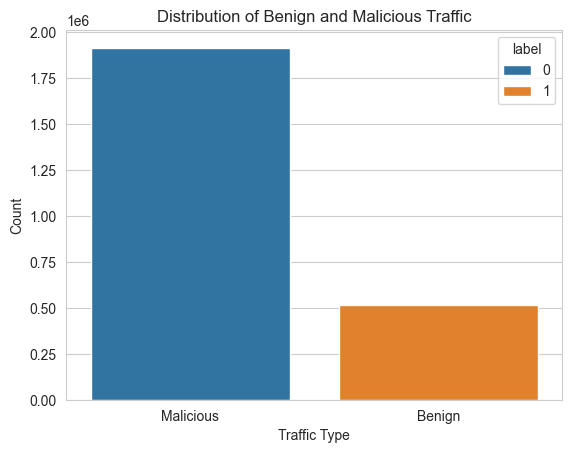

In [5]:
X = dataframe.drop('label', axis=1)
y = dataframe['label']

print(X.shape)

sns.countplot(x='label', data=dataframe, hue='label')
plt.xticks([0, 1], ['Malicious', 'Benign'])
plt.xlabel('Traffic Type')
plt.ylabel('Count')
plt.title('Distribution of Benign and Malicious Traffic')
plt.savefig('results/benign_malicious_traffic.png')
plt.show()


We have a large dataset that contains more than two million rows and has 23 features, and has **more** Malicious traffic than Benign traffic (3.5x more).

### Split Data into Training and Test Sets
The training set will be used to train the model, while the test set will be used to evaluate the model's performance. For this project, we will use a `70/30` split.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42)

print("Train set: ", X_train.shape, y_train.shape)
print("Test set: ", X_test.shape, y_test.shape)

Train set:  (1698601, 23) (1698601,)
Test set:  (727973, 23) (727973,)


### Feature Scaling
Feature scaling is a method used to normalize the range of independent variables or features of data. In this case we used the `MinMaxScaler()` which obtains the **minimum** and **maximum** values of the dataset and does this operation to the features 

```scaled_value = (value - min) / (max - min)```

In [6]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Building and fitting
### Grid Search Training
We will train three different models using Grid Search. Grid Search is a method of hyperparameter tuning that will try all the combinations of hyperparameters and select the best one. The **three models** we will use are:
1. **Logistic Regression:** Because simple, interpretable, and computationally efficient, and it works well when the relationship between features and the target variable is approximately linear.
2. **Random Forest:** Because it's robust to overfit, handles non-linearity well, and can capture complex relationships in the data.
3. **XGBoost:** Highly accurate, handles non-linearity, and feature interactions well.

In [7]:
models = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'C': [1, 10, 100],
            'max_iter': [1000]
        },
        'solver': 'liblinear'
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 5, 10],
            'learning_rate': [0.01, 0.1],
            'gamma': [0, 0.1],
            'reg_lambda': [0, 1]
        }
    }
}

## Evaluation and Data visualization
Here we will evaluate the performance of the models using multiple metrics, such as **accuracy**, **precision**, **recall**, **F1 score**, **confusion matrix**, and **ROC curve**.

The confusion matrix is a table composed by **four values**, and the main goal is to have the **highest number of values in the diagonal**. The four values are:
- **True Positive (TP):** The model predicted the positive class correctly.
- **True Negative (TN):** The model predicted the negative class correctly.
- **False Positive (FP):** The model predicted the positive class incorrectly.
- **False Negative (FN):** The model predicted the negative class incorrectly.

The **accuracy** is the ratio of the correct predictions to the total number of predictions. It is a good metric when the classes are **balanced**.

The **precision** is the ratio of the true positives to the number of true positives plus the number of false positives. It is a good metric when the **cost of false positives is high**.

The **recall** is the ratio of the true positives to the number of true positives plus the number of false negatives. It is a good metric when the **cost of false negatives is high**.

The **F1 score** is the harmonic mean of precision and recall. It is a good metric when we want to **seek a balance between precision and recall**.

The **ROC curve** is a plot of the true positive rate (TPR) against the false positive rate (FPR). It is a good metric when the **cost of false positives and false negatives is similar**. The **area under the curve (AUC)** is a measure of how well a parameter can distinguish between two groups. An area of 1 represents a perfect test, while an area of 0.5 represents a worthless test.

Training LogisticRegression
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END .................................C=1, max_iter=1000; total time=   9.9s
[CV] END .................................C=1, max_iter=1000; total time=   8.0s
[CV] END .................................C=1, max_iter=1000; total time=   7.5s
[CV] END ................................C=10, max_iter=1000; total time=  14.0s
[CV] END ................................C=10, max_iter=1000; total time=  14.0s
[CV] END ................................C=10, max_iter=1000; total time=  11.8s
[CV] END ...............................C=100, max_iter=1000; total time=  30.3s
[CV] END ...............................C=100, max_iter=1000; total time=  31.2s
[CV] END ...............................C=100, max_iter=1000; total time=  27.4s
Best parameters for LogisticRegression: {'C': 100, 'max_iter': 1000}
Best score for LogisticRegression: 0.999543742180638
Accuracy score for LogisticRegression: 0.9995769073853014
Clas

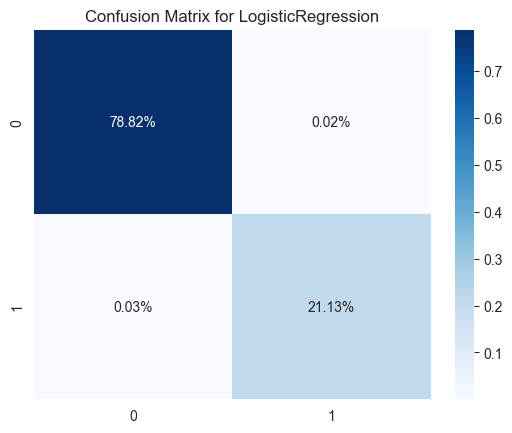

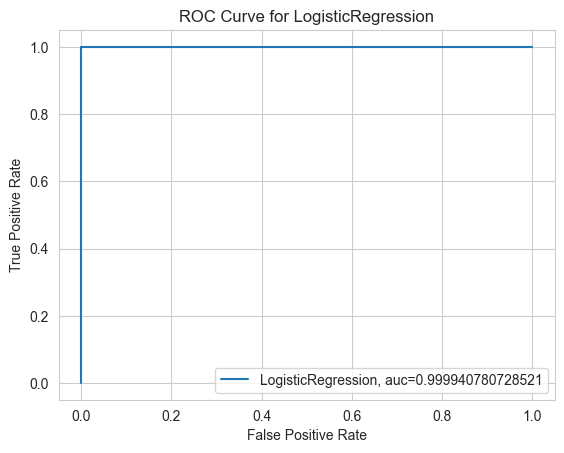

Training RandomForestClassifier
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 4.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 4.3min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 4.2min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 7.9min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 8.3min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 8.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 3.9min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 3.8min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;

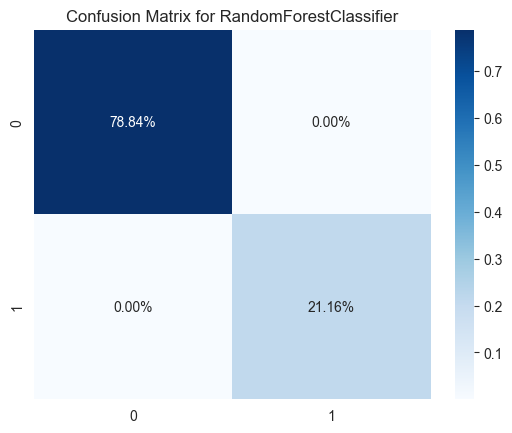

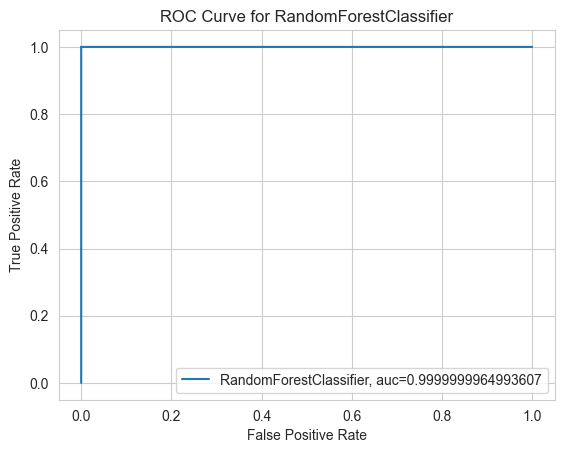

Training XGBClassifier
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   5.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   4.8s
[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   4.9s
[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=   4.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=   4.3s
[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=   4.3s
[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=0; total time=   8.8s
[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=0; total time=   8.6s
[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg

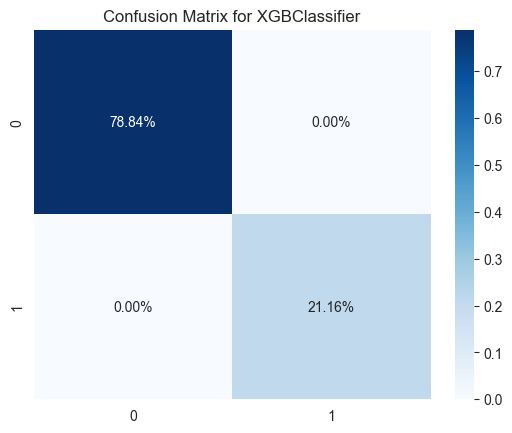

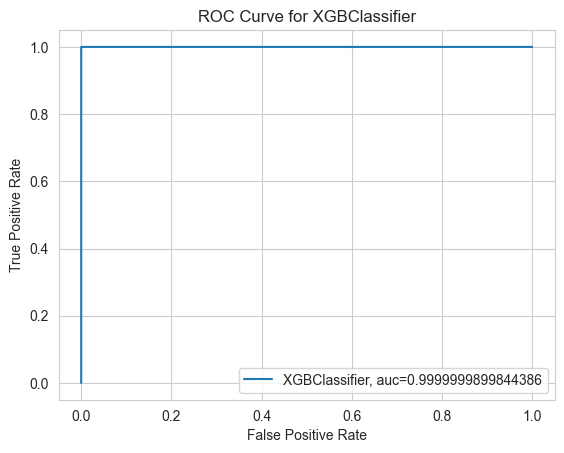

In [8]:
for model_name, model_params in models.items():
    print(f"Training {model_name}")
    clf = GridSearchCV(model_params['model'], model_params['params'], cv=3, verbose=2)
    clf.fit(X_train, y_train)
    
    print(f"Best parameters for {model_name}: {clf.best_params_}")
    print(f"Best score for {model_name}: {clf.best_score_}")
    
    y_pred = clf.predict(X_test)
    
    print(f"Accuracy score for {model_name}: {accuracy_score(y_test, y_pred)}")
    print(f"Classification report for {model_name}: \n{classification_report(y_test, y_pred)}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.savefig(f"results/{model_name}_confusion_matrix.png")
    plt.show()
    
    # ROC Curve
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{model_name}, auc={auc(fpr, tpr)}")
    plt.title(f"ROC Curve for {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.savefig(f"results/{model_name}_ROC.png")
    plt.show()

As we can see, all the models performed well, with values between 99 and 100 percent. Because of the size of the dataset, almost all the statistics are very high, and the ROC curve is almost perfect. However, the **Random Forest Classifier** took much longer to train. So in that case, we will compare the **Logistic Regression** and **XGBoost models** (with the parameters previously found the best ones) to check if there's a **significant difference** between the two models.

## McNemar's statistic
After training the models, we noticed that between the three models, the Random Forest Classifier performed the best, however, it took much longer to train. So in that case, we will compare the **Logistic Regression** and **XGBoost models** (with the parameters previously found the best ones) using McNemar's statistic, to check if there's a **significant difference** between the two models. 

The **p-value** in McNemar statistics represents the probability of obtaining the observed result (or more extreme results) under the null hypothesis. The null hypothesis in McNemar's test is that there is no significant difference in proportions between the two groups. If the p-value is less than the significance level (in this case, `0.05`), then we can reject the null hypothesis and conclude that there is a significant difference between the two models.

Logistic Regression train loss: 0.0025261803204122287
XGBoost train loss: 7.628906473595571e-06


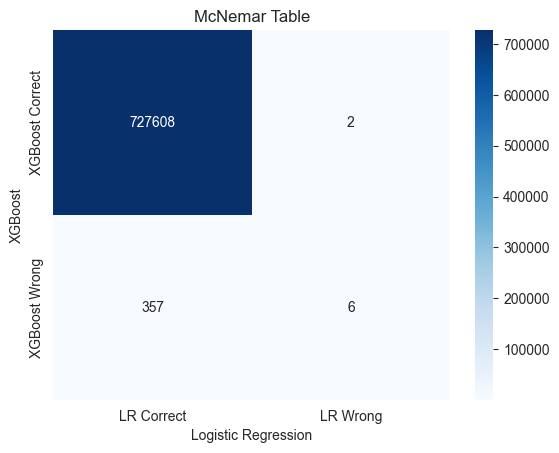

McNemar's Test Statistic: 150.0
p-value: 0.0021612733742205708
There is a significant difference in the performance of the two models.


In [12]:
# Train Logistic Regression model
lr_clf = LogisticRegression(C=100, max_iter=1000, solver='liblinear')
lr_clf.fit(X_train, y_train)
lr_y_pred = lr_clf.predict(X_test)

lr_train_loss = log_loss(y_train, lr_clf.predict_proba(X_train))
print(f"Logistic Regression train loss: {lr_train_loss}")

# Save the model
joblib.dump(lr_clf, 'models/logistic_regression.pkl')

# Train XGBoost model
xgb_clf = XGBClassifier(gamma=0, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=0)
xgb_clf.fit(X_train, y_train)
xgb_y_pred = xgb_clf.predict(X_test)

xgb_train_loss = log_loss(y_train, xgb_clf.predict_proba(X_train))
print(f"XGBoost train loss: {xgb_train_loss}")

# Save the model
joblib.dump(xgb_clf, 'models/xgboost.pkl')

# Perform McNemar's Test
tb = pd.crosstab(lr_y_pred, xgb_y_pred)
result = mcnemar(tb, exact=True)

# Create a McNemar table
table = mcnemar_table(y_test, lr_y_pred, xgb_y_pred)
sns.heatmap(table, annot=True, fmt='d', xticklabels=['LR Correct', 'LR Wrong'], yticklabels=['XGBoost Correct', 'XGBoost Wrong'])
plt.xlabel('Logistic Regression')
plt.ylabel('XGBoost')
plt.title('McNemar Table')
plt.savefig('results/mcnemar_table.png')
plt.show()


# Print McNemar's Test result
print("McNemar's Test Statistic:", result.statistic)
print("p-value:", result.pvalue)

# Check significance difference
significance_level = 0.05
if result.pvalue < significance_level:
    print("There is a significant difference in the performance of the two models.")
else:
    print("There is no significant difference in the performance of the two models.")

As we can see, the train loss from the Logistic Regression model (`0.0025` or `0.25%`) is higher than the train loss from the XGBoost model (`0.0000076289` or `0.00076289%`). This means that the XGBoost model is more accurate than the Logistic Regression model.

The **p-value** is less than the significance level (`0.05`), so we can reject the null hypothesis and conclude that there is a **significant difference** between the two models. And from the contingency table, we can see that the **Logistic Regression model** has **more correct predictions** than the **XGBoost model**.

## Feature Importance
Feature importance assigns a **score** to input features based on **how useful they are at predicting** a target variable.

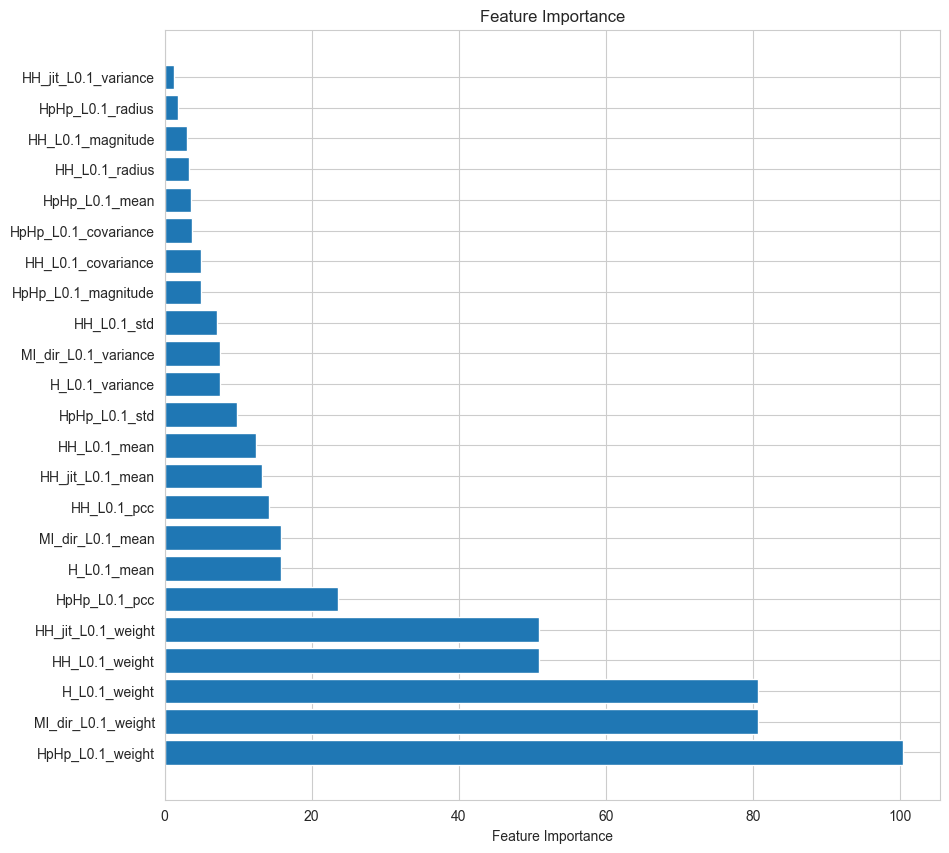

In [10]:
feature_importance = np.abs(lr_clf.coef_[0])
feature_names = dataframe.drop('label', axis=1).columns

# Sort the feature importance by most important first
idx = np.argsort(feature_importance)[::-1]
feature_importance = feature_importance[idx]
feature_names = feature_names[idx]

# Plot the feature importances
plt.figure(figsize=(10, 10))
plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(range(len(feature_importance)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.savefig('results/feature_importance.png')
plt.show()

We can also conclude that the **most important five features** that contribute the most to the classification are:
1. **HpHp_L0.1_weight:** Conditional Entropy for a direct connection with a lag of 0.1 (weight).
2. **MI_dir_L0.1_weight:** Mutual Information for a direct connection with a lag of 0.1 (weight).
3. **H_L0.1_weight:** Entropy for a direct connection with a lag of 0.1 (weight).
4. **HH_L0.1_weight:** Joint Entropy for a direct connection with a lag of 0.1 (weight).
5. **HH_jit_L0.1_weight:** Joint Entropy for a direct connection with a lag of 0.1 (weight).

## Conclusion
In summary, we have explored the use of binary classification to differentiate between normal and malicious activities within IoT ecosystems. We have trained three different models using Grid Search, and evaluated their performance using multiple metrics. We have also checked if there's a significant difference between the performance of the two best models. We concluded that the Logistic Regression model performed the best, and that there is a significant difference between the performance of the Logistic Regression and XGBoost models. Finally, we have identified the most important features that contribute the most to the classification.